# Qiskit Workshop: Computing molecular energy states with Qiskit Nature



In [2]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [3]:
# Import other needed libraries
import numpy as np
import matplotlib.pyplot as plt

---

## Introduction

**Goal**: Solve non-relativistic time independent Schroedinger equation,

<center>
    $\mathcal{H}_{\text{el}} |\Psi_{n}\rangle = E_{n} |\Psi_{n}\rangle$
</center>

to find the energies $E_n$. The ground state energy, $E_0$, given by:

<center>
    $E_0 = \frac{\langle \Psi_0 | H_{\text{el}} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}$
</center>

**Solution**: Use eigenvalue solver to find energies $E_n$.

---

## Qiskit Nature features
- Interfaces to common classical chemistry libraries/programs ("drivers")
    - Gaussian
    - PSI4
    - PyQuante
    - PYSCF
- Functions to map various operators to qubit operators
- Common ansatz preparation circuits for variational solvers

---

## Setting up the problem

### Step 1: Create molecule and the driver

In [4]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

# Create molecule
molecule = MoleculeInfo(['H', 'H'], [(0., 0., 0.), (0., 0., 0.735)],
                        charge=0, 
                        multiplicity=1)

# Instantiate driver
driver = PySCFDriver.from_molecule(molecule = molecule, basis='sto3g')

AttributeError: module 'numpy' has no attribute 'typeDict'

<br>

*Step 2a:* Get the `ElectronicStructureProblem` object by running the driver and compute Second quantization operator

In [4]:
es_problem = driver.run()
second_q_op = es_problem.hamiltonian.second_q_op()
print(second_q_op)

Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211565 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211556 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211565 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211556 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.33229086512764816 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211564 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764816 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211564 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211565 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211556 * ( +_2 +_1 -_0 -_3 )
+ 0.33229086512764827 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507740175813 * ( +_2 +_2 -_2 -_2 )
+ 0.0904655998921

<br>

*Step 2b:* Map to qubit spin operators

Available mappings:
- Jordan-Wigner
- Parity
- Bravyi-Kitaev

In [5]:
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter

jw_qubit_converter = QubitConverter(mapper=JordanWignerMapper())
jw_qubit_op = jw_qubit_converter.convert(second_q_op)
print(jw_qubit_op)

-0.8105479805373283 * IIII
+ 0.17218393261915543 * IIIZ
- 0.2257534922240237 * IIZI
+ 0.12091263261776633 * IIZZ
+ 0.17218393261915543 * IZII
+ 0.16892753870087907 * IZIZ
+ 0.045232799946057826 * YYYY
+ 0.045232799946057826 * XXYY
+ 0.045232799946057826 * YYXX
+ 0.045232799946057826 * XXXX
- 0.22575349222402363 * ZIII
+ 0.1661454325638241 * ZIIZ
+ 0.16614543256382408 * IZZI
+ 0.1746434306830045 * ZIZI
+ 0.12091263261776633 * ZZII


In [6]:
from qiskit_nature.second_q.mappers import ParityMapper

pr_qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
pr_qubit_op = pr_qubit_converter.convert(second_q_op, num_particles=es_problem.num_particles)
print(pr_qubit_op)

-1.0523732457728605 * II
+ 0.39793742484317896 * IZ
- 0.39793742484317896 * ZI
- 0.01128010425623538 * ZZ
+ 0.18093119978423122 * XX


---

## Solve for ground state energy using VQE

<img src=https://qiskit.org/documentation/nature/_images/vqe.png width=1000px>

### Step 1: Create VQE solver

#### Method A: Create/Instatiate a parameterized ansatz circuit, then pass to `VQE` class

Available ansatz circuits / variational forms:
- `TwoLocal`
- `EfficientSU2`
- `UCC` (Unitary coupled cluster)

In [7]:
n = jw_qubit_op.num_qubits
#n = pr_qubit_op.num_qubits

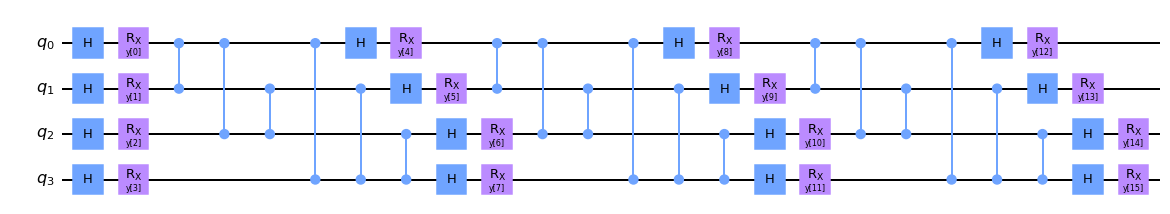

In [8]:
from qiskit.circuit.library import TwoLocal

tl_circ = TwoLocal(num_qubits = n, rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz',
                      entanglement='full', reps=3, parameter_prefix = 'y')
tl_circ.decompose().draw()

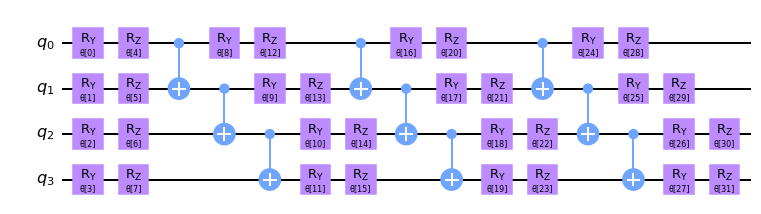

In [9]:
from qiskit.circuit.library import EfficientSU2

su2_circ = EfficientSU2(num_qubits=n, entanglement='linear')
su2_circ.decompose().draw()

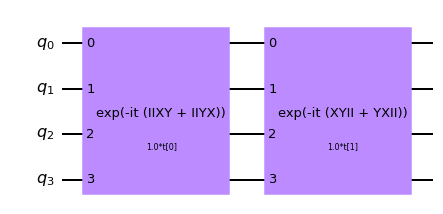

In [10]:
from qiskit_nature.circuit.library import UCC

ucc_circ = UCC(excitations='s',
               qubit_converter=jw_qubit_converter, 
               num_particles=es_problem.num_particles, 
               num_spin_orbitals=2*es_problem.num_spatial_orbitals)
ucc_circ.decompose().draw()

<br> 

Now, create the VQE solver with the desired ansatz

In [21]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SLSQP, COBYLA

vqe_solver = VQE(Estimator(), su2_circ, COBYLA())

<br>

#### Method B: Use pre-built ansatz+VQE from factory class

In [12]:
from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCCSD

# Instantiate the VQE solver with the Unitary Coupled Cluster (UCCSD) ansatz
vqeucc_solver = VQEUCCFactory(Estimator(), UCCSD(), SLSQP())

<br>

### Step 2: Run ground state solver

In [13]:
# Choose your converter!

# JW mapping (uses 4 qubits)
qubit_converter = jw_qubit_converter

# Parity mapping using 2 qubits
#qubit_converter = pr_qubit_converter

<br> 

Using the `VQE` class with `EfficientSU2`

In [24]:
# Callback function to display intermediate results
def callback(eval_count, params, value, metadata):
    if eval_count % 10 == 0:
        print("Iteration:", eval_count, " value=", value)
    
vqe_solver.callback = callback

In [15]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

In [25]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

# Using the VQE class with EfficientSU2 ansatz
su2_gsc = GroundStateEigensolver(qubit_converter, vqe_solver)
result = su2_gsc.solve(es_problem)

print(result)

Iteration: 10  value= -1.0267367456520897
Iteration: 20  value= -0.9183593495070608
Iteration: 30  value= -1.1422002839679588
Iteration: 40  value= -1.06314406543205
Iteration: 50  value= -1.2708397646226777
Iteration: 60  value= -1.3432034031235096
Iteration: 70  value= -1.3438277548312718
Iteration: 80  value= -1.5417754431521233
Iteration: 90  value= -1.4918637098136112
Iteration: 100  value= -1.6587543961305957
Iteration: 110  value= -1.6057750659616932
Iteration: 120  value= -1.664461679519049
Iteration: 130  value= -1.7215968149525174
Iteration: 140  value= -1.7358997528664988
Iteration: 150  value= -1.7599810846217163
Iteration: 160  value= -1.7813140316895968
Iteration: 170  value= -1.8020529429197654
Iteration: 180  value= -1.8079421745387254
Iteration: 190  value= -1.8301981561571723
Iteration: 200  value= -1.824001059768991
Iteration: 210  value= -1.8315319692270897
Iteration: 220  value= -1.8379112213541997
Iteration: 230  value= -1.8402370131785606
Iteration: 240  value= -

<br>

Using `VQEUCCFactory`

In [21]:
# Using the VQE UCC Factory class solver
ucc_gsc = GroundStateEigensolver(qubit_converter, vqeucc_solver)
result = ucc_gsc.solve(es_problem)

print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894866]
    - computed part:      [0.0  0.0  1.38894866]
  > Dipole moment (a.u.): [0.0  0.0  0.00000004]  Total: 0.00000004
                 (debye): [0.0  0.0  0.00000011]  Total: 0.00000011
 


<br>

Check against classical solver

In [17]:
# Check against classical solver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

np_gsc = GroundStateEigensolver(qubit_converter, numpy_solver)
np_result = np_gsc.solve(es_problem)

print(np_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


---

## Calculating bond dissociation profile

### Step 1: Create molecule with `degrees_of_freedom` parameter

In [18]:
# Specify degree of freedom (points of interest)
n_points = 10
points = np.linspace(0.25, 2, n_points)

<br>

### Step 2: Compute potential energy surface using by changing the atom distance

In [19]:
energies = []
for dist in points:
    molecule.coords[1] = (0., 0., dist)
    driver = PySCFDriver.from_molecule(molecule = molecule, basis='sto3g')
    problem = driver.run()
    su2_gsc = GroundStateEigensolver(qubit_converter, vqe_solver)
    result = su2_gsc.solve(problem)
    energies.append(result.total_energies)    
    print("Distance:", dist, ", energy:", result.total_energies)

Distance: 0.25 , energy: [-0.31225269]
Distance: 0.4444444444444444 , energy: [-0.990597]
Distance: 0.6388888888888888 , energy: [-1.11109142]
Distance: 0.8333333333333334 , energy: [-1.13054769]
Distance: 1.0277777777777777 , energy: [-1.09516831]
Distance: 1.2222222222222223 , energy: [-1.05182672]
Distance: 1.4166666666666667 , energy: [-1.0124047]
Distance: 1.6111111111111112 , energy: [-0.98200569]
Distance: 1.8055555555555556 , energy: [-0.96134827]
Distance: 2.0 , energy: [-0.93992748]


Text(0, 0.5, 'Energy')

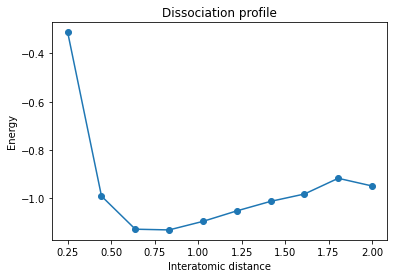

In [24]:
# Plot
fig = plt.figure()
plt.plot(points, energies, marker='o')
plt.title('Dissociation profile')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')

---

## Computing excited state energies

<img src=https://qiskit.org/documentation/nature/_images/H2_es.png width=200>

Use *Quantum equation of motion* (QEOM) method.

See article: P. Allitrault et al, [arxiv 1910.12890](https://arxiv.org/abs/1910.12890)

In [18]:
from qiskit_nature.second_q.algorithms import QEOM

qeom_solver = QEOM(ucc_gsc, Estimator(), "sd")

qeom_results = qeom_solver.solve(es_problem)

print(qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -1.244586751054
> Total excited state energy (Hartree): -0.524617756605
  2: 
* Electronic excited state energy (Hartree): -0.882724351456
> Total excited state energy (Hartree): -0.162755357007
  3: 
* Electronic excited state energy (Hartree): -0.22491345405
> Total excited state energy (Hartree): 0.495055540399
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894893]
    - computed part:      [0.0  0.0  1.38894893]
  > Dipole moment (a.u.): [0.0  0.0  -0.00000023]  Total: 0.00000023
      

## Ground State Calculation using the Qiskit Runtime

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import Estimator

service = QiskitRuntimeService()

In [27]:
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_oslo')>]

In [28]:
runtime_sim_backend = service.get_backend('ibmq_qasm_simulator')

In [30]:
with Session(backend=runtime_sim_backend) as session:
    estimator = Estimator(session=session)
    runtime_vqe_solver = VQE(estimator, su2_circ, COBYLA(), callback=callback)
    runtime_su2_gsc = GroundStateEigensolver(qubit_converter, runtime_vqe_solver)
    result = runtime_su2_gsc.solve(es_problem)
    
print(result)        

Iteration: 10  value= -0.8667534695959217
Iteration: 20  value= -0.9815412588930799
Iteration: 30  value= -1.0187898004798666
Iteration: 40  value= -1.0567644517770627
Iteration: 50  value= -1.179149588296833
Iteration: 60  value= -1.2402867968093978
Iteration: 70  value= -1.2643309777791925
Iteration: 80  value= -1.4662747545561494
Iteration: 90  value= -1.4517147139195745
Iteration: 100  value= -1.5086903149722923
Iteration: 110  value= -1.6368206576180122
Iteration: 120  value= -1.6938174174132223
Iteration: 130  value= -1.6840212072717313
Iteration: 140  value= -1.7127275535320932
Iteration: 150  value= -1.7424615205042366
Iteration: 160  value= -1.7515933116794233
Iteration: 170  value= -1.7353576494691714
Iteration: 180  value= -1.7534513844589408
Iteration: 190  value= -1.753602516789699
Iteration: 200  value= -1.7568906673374434
Iteration: 210  value= -1.763252769529356
Iteration: 220  value= -1.7720353620818865
Iteration: 230  value= -1.7673018421647586
Iteration: 240  value= 

## Noisy Simulation

In [31]:
from qiskit.providers.fake_provider import FakeBelem
from qiskit_aer.noise import NoiseModel

fake_noisy_backend = FakeBelem()
noise_model = NoiseModel.from_backend(fake_noisy_backend)

In [34]:
from qiskit_ibm_runtime import Options

options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_noisy_backend.configuration().basis_gates,
    "coupling_map": fake_noisy_backend.configuration().coupling_map,
    "seed_simulator": 42
}

options.execution.shots = 1024
options.optimization_level = 0
options.resiliance_level = 0

In [36]:
with Session(backend=runtime_sim_backend) as session:
    estimator = Estimator(session=session, options=options)
    runtime_vqe_solver = VQE(estimator, su2_circ, COBYLA(), callback=callback)
    runtime_su2_gsc = GroundStateEigensolver(qubit_converter, runtime_vqe_solver)
    result = runtime_su2_gsc.solve(es_problem)
    
print(result)    

Iteration: 10  value= -0.9173104422841999
Iteration: 20  value= -0.9368500171324754
Iteration: 30  value= -1.0222358205012503
Iteration: 40  value= -1.1161217483900086
Iteration: 50  value= -1.1808567932573633
Iteration: 60  value= -1.149445053273609
Iteration: 70  value= -1.2619005012855031
Iteration: 80  value= -1.2163566704025335
Iteration: 90  value= -1.3215160483501323
Iteration: 100  value= -1.283476621268391
Iteration: 110  value= -1.3333071960527538
Iteration: 120  value= -1.3379184895881355
Iteration: 130  value= -1.3684673529096667
Iteration: 140  value= -1.3233103787113154
Iteration: 150  value= -1.377821728406495
Iteration: 160  value= -1.4201055120900636
Iteration: 170  value= -1.38710981225051
Iteration: 180  value= -1.360682348685994
Iteration: 190  value= -1.3551395927552448
Iteration: 200  value= -1.3547897271210925
Iteration: 210  value= -1.3714908668566506
Iteration: 220  value= -1.3156621589314117
Iteration: 230  value= -1.399135866783236
Iteration: 240  value= -1.3

## Use Error Suppression and Mitigation

In [38]:
# Use Dynamic Decoupling
options.optimization_level = 1

# Use Zero-noise extrapolation
options.resiliance_level = 2
 
with Session(backend=runtime_sim_backend) as session:
    estimator = Estimator(session=session, options=options)
    runtime_vqe_solver = VQE(estimator, su2_circ, COBYLA(), callback=callback)
    runtime_su2_gsc = GroundStateEigensolver(qubit_converter, runtime_vqe_solver)
    result = runtime_su2_gsc.solve(es_problem)
    
print(result) 

Iteration: 10  value= -1.0227494935248815
Iteration: 20  value= -1.1636407466617968
Iteration: 30  value= -1.3730564124889173
Iteration: 40  value= -1.3700968133323221
Iteration: 50  value= -1.441637184640618
Iteration: 60  value= -1.4359485611685185
Iteration: 70  value= -1.5467493059572393
Iteration: 80  value= -1.5041639424195923
Iteration: 90  value= -1.5414908881908196
Iteration: 100  value= -1.4954000598111281
Iteration: 110  value= -1.5556716937796158
Iteration: 120  value= -1.549464329886458
Iteration: 130  value= -1.559799419008014
Iteration: 140  value= -1.5903533891935193
Iteration: 150  value= -1.5682916879136606
Iteration: 160  value= -1.552031716466451
Iteration: 170  value= -1.5648546709203366
Iteration: 180  value= -1.599293978419218
Iteration: 190  value= -1.582555147368271
Iteration: 200  value= -1.5799997773338095
Iteration: 210  value= -1.57611132722297
Iteration: 220  value= -1.5537865511287958
Iteration: 230  value= -1.5675022825610914
Iteration: 240  value= -1.57

In [33]:
%qiskit_version_table